<a href="https://colab.research.google.com/github/Beerschtein/PyTorch/blob/main/HW_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>Generative Adversarial Networks</center></h1>

## Домашнее задание 8
1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

### Загрузим библиотеки


In [16]:
import pandas as pd
import numpy as np
import math

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython import display

In [17]:
device = 'cpu'
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

### Сгенерируем данные

In [18]:
df = pd.DataFrame(np.linspace(-20, 20, 15000), columns=['x'])
df['y'] = np.sin(df['x']) / df['x'] - (df['x'] / 10)
df.head()

,x,y
0,-20.000000,2.045647
1,-19.997333,2.045332
2,-19.994666,2.045017
3,-19.991999,2.044701
4,-19.989333,2.044385


### Построим график функции

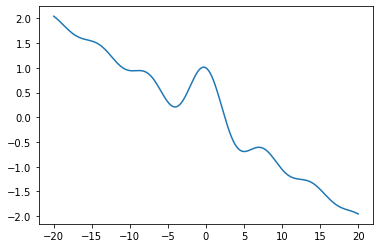

In [19]:
plt.plot(df['x'], df['y'])
plt.show()

### Создадим модель

### Генератор

In [20]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Создадим словарь с функциями активации
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        # метод для построения блоков задач, активацию возьмем из словаря выше
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  

            if normalize:
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает 
            # тоже самое что и layers.append(nn.LeakyReLU(0.2, inplace=True))
            
            return layers

        self.model = nn.Sequential(
            # Звездочка означает unpacking списка
            *block(latent_dim, 128, normalize=False), 
            *block(128, 256, activation='lrelu'),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, 2),
        )
        
    # при форварде прогоняем данные через модель
    def forward(self, z):
        num = self.model(z)
        return num

### Создадим пользовательский слой для использования внутри модели

In [21]:
class CustomLinearLayer(nn.Module):
    def __init__(self, size_in, size_out):
        # забираем все методы
        super().__init__()
        # инициализируем веса
        self.size_in, self.size_out = size_in, size_out
        
        weights = torch.Tensor(size_out, size_in)
        # в PyTorch если объект имеет класс параметров, то он обучаемый,
        # т.е. через него будут прогоняться градиенты
        self.weights = nn.Parameter(weights) 

        # подготавливаем переменные для сдвига bias
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)
        
        # инициализируем веса и смещения (байесы) близкими к нулю значениями
        # в данном примере если поставить -0,005 и 0,005, обучается дольше и хуже
        nn.init.uniform_(self.weights, -0.5, 0.5) 
        nn.init.uniform_(self.bias, -0.5, 0.5)  

    def forward(self, x):
        # По формуле линейного слоя, нам нужно умножить наши данные 
        # на транспонированные веса и добавить смещение
        w_times_x = torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)

### Дискриминатор

In [22]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        # на входе размерность, на выходе классфицируем правда/ложь
        self.model = nn.Sequential(
            CustomLinearLayer(2, 512),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            CustomLinearLayer(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, pred):
        validity = self.model(pred)
        # классифицируем false/true
        return validity

### Инициализация

In [23]:
n_epochs = 100
batch_size = 32
lr = 0.0005

b1 = 0.5
b2 = 0.999

latent_dim = 1000

sample_interval = 100

# Преобразуем Датафрейм в массив

real_data = torch.utils.data.DataLoader(
    df.to_numpy(), # to_numpy()
    batch_size=batch_size,
    shuffle=True)

real_data

### Перейдем на GPU

In [24]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

### Зададим оптимизаторы и функцию ошибки 

In [30]:
# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

orange_patch = mpatches.Patch(color='orange', label='D loss')
blue_patch = mpatches.Patch(color='blue', label='G loss')

### Подготовим списки для учета ошибок Генератора и Дискриминатора

In [26]:
d_loss_history = []
g_loss_history = []

### Процесс обучения

[Epoch 99/100] [Batch 369/469] [D loss: 0.687589] [G loss: 0.695002]


<Figure size 432x288 with 0 Axes>

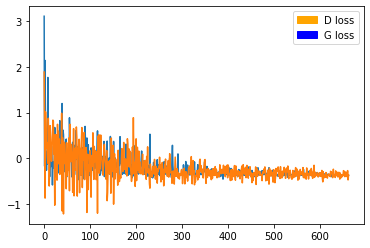

In [31]:
for epoch in range(n_epochs):
    for i, data in enumerate(real_data):
        
        cur_batch_size = len(data)

##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        # valid = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(1.0), requires_grad=False).to(device)
        # fake = Variable(torch.FloatTensor(cur_batch_size, 1).fill_(0.0), requires_grad=False).to(device)

        # истинные значения
        valid = torch.FloatTensor(cur_batch_size, 1).fill_(1.0).to(device)
        # ложные значения
        fake = torch.FloatTensor(cur_batch_size, 1).fill_(0.0).to(device)

        # генерация шума (нормальное распределение тут не подойдёт)
        z = Variable(torch.FloatTensor(np.random.uniform(-50, 50, (cur_batch_size, latent_dim)))).to(device)
        
        # реальные значения перекладываем на устройство
        real_ex = Variable(data.type(torch.FloatTensor)).to(device)

        # Генерируем данные Генератором на основе шума
        gen_data = generator(z)


######################  Тренировка дискриминатора    ##########################

        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_ex)

        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        # получаем бинарную кросс-энтропию
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор
        fake_pred = discriminator(gen_data.detach())
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        # обновляем градиенты
        optimizer_D.zero_grad()
        
        # подсчёт градиентов
        d_loss.backward()
        
        # шаг оптимизации
        optimizer_D.step()
        
######################  Тренировка генератора    ##########################

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_data)
        
        # Тут сравниваем предсказанные значения Дискриминатора 
        # (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()
        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(real_data) + i
    
        if batches_done % sample_interval == 0:
            plt.clf()
            
            display.clear_output(wait=False)
            print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]"% (epoch, n_epochs, i, len(real_data), d_loss.item(), g_loss.item()) ) 

            display.display(plt.gcf())

            # d_loss и g_loss - тензоры, чтобы поместить их в список,
            # извлекаются без граадиента методом detach()
            d_loss_history.append(d_loss.detach().numpy())
            g_loss_history.append(g_loss.detach().numpy())
            
            plt.plot(np.log(np.array(d_loss_history)), label='D loss')
            plt.plot(np.log(np.array(g_loss_history)), label='G loss')

            plt.legend(handles=[orange_patch, blue_patch])
            plt.show()

### Визуально посмотрим насколько предсказанные данные близки к настоящим

In [32]:
generator.eval()

# Для этого сгенерируем тестовый тензор
test_z = Variable(torch.from_numpy(np.random.uniform(-40, 35, (100, latent_dim)).astype(np.float64)).float()).to(device)

with torch.no_grad():
    test_pred = generator(test_z)

In [33]:
nt = 0
error = 0.0
count = 0
for i in range(len(test_pred)):
    x = test_pred[i][0]
    y_real = (np.sin(x) / x) - (x / 10) 
    y_pred = test_pred[i][1]  
    count +=1
    error += abs(y_real - y_pred)

print("Mean error: %.10f" % (error/count))

Mean error: 0.0369092524


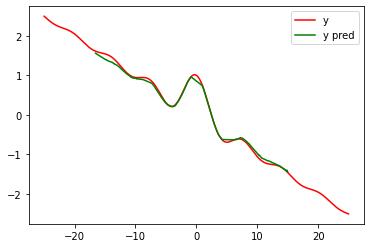

In [34]:
plt.figure()

x = np.linspace(-25, 25, 1000)
plt.plot(x, ((np.sin(x) / x) - (x / 10) ), label='y')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred')

plt.legend()
plt.show()

### Заметил закономерность - чем большее количество данных содержит тестовый датасет, тем лучше работает модель и точнее предсказания.  